# Projekt LL17 z przedmiotu USD.
realizowany przez Jakuba Frydrycha i Mateusza Borkowskiego



##Instrukcja obsługi
Kod powinien wykonać się bez problemu zapisując i wczytując wytrenowane polityki w tymczasowym folderze sesji. Kod został stworzony z myślą o działaniu w środowisku Google Colab, i nie był testowany w innych środowiskach.

Najłatwiejszym sposobem na uruchomienie programu (w środowisku Colab) jest wciśnięcie Cmd/Ctr+F9, lub wybranie opcji "Run All" z zakładki Runtime.

Na ten moment nie zaimplementowane zostało wczytywanie wytrenowanych polityk (https://github.com/google/brax/discussions/403) Konieczne jest trenowanie każdej polityki od nowa.

Do wysłanego projektu załączony został folder z nagraniami działania omawianych w dokumentacji końcowej modeli.

Ważniejsze zmienne:
* num_timesteps - definiuje długość treningu
* savepath - miejsce zapisu plików programu
* forward_reward_weigh, ctrl_cost_weight, healthy_reward - wagi funkcji nagród

W obecnej postaci trening na GPU T4 powinien zająć ok. 20min

In [ ]:
#@title Informacje o przydzielonym GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Feb  2 22:41:20 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
#@title Instalacja brakujących w Colabie bibliotek

!pip install -q mujoco
!pip install -q mujoco_mjx
!pip install -q brax

!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy

In [ ]:
#@title Umożliwienie wyświetlania wyników w Colabie

#from google.colab import files

import distutils.util
import os
import subprocess
if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.')

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
  with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
    f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

try:
  print('Checking that the installation succeeded:')
  import mujoco
  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')

print('Installation successful.')

Setting environment variable to use GPU rendering:
env: MUJOCO_GL=egl
Checking that the installation succeeded:
Installation successful.


In [ ]:
#@title Importowanie Bibliotek
import sys
import time
import pytz
from datetime import datetime, timedelta
import numpy as np

import mujoco
from mujoco import mjx

import jax
from jax import numpy as jp

from brax import base
from brax import envs
from brax import math
from brax.base import Base, Motion, Transform
from brax.envs.base import Env, MjxEnv, State
from brax.mjx.base import State as MjxState

from brax.training.agents.ppo import train as ppo
from brax.training.agents.ppo import networks as ppo_networks
from brax.training.agents.sac import train as sac

from brax.io import html, mjcf, model

import mediapy as media
import matplotlib.pyplot as plt
from IPython.display import HTML
from datetime import datetime
import functools


from etils import epath


from ml_collections import config_dict
from flax import struct
import itertools
from typing import Callable, NamedTuple, Optional, Union, List
np.set_printoptions(precision=3, suppress=True, linewidth=100)

/usr/local/lib/python3.10/dist-packages/chex/_src/pytypes.py:53: DeprecationWarning: jax.core.Shape is deprecated. Use Shape = Sequence[int | Any].
  Shape = jax.core.Shape
/usr/local/lib/python3.10/dist-packages/chex/_src/pytypes.py:54: DeprecationWarning: jax.random.KeyArray is deprecated. Use jax.Array for annotations, and jax.dtypes.issubdtype(arr.dtype, jax.dtypes.prng_key) for runtime detection of typed prng keys (i.e. keys created with jax.random.key).
For more information, see https://jax.readthedocs.io/en/latest/jep/9263-typed-keys.html
  PRNGKey = jax.random.KeyArray


In [ ]:
#@title Sprawdzenie wersji Bibliotek
print("Python version: " + sys.version)
print("MuJoCo version: " + mujoco.__version__)
print("NumPy version: " + np.__version__)
print("Jax version: " + jax.__version__)
print("MediaPy version: " + media.__version__)

Python version: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
MuJoCo version: 3.1.1
NumPy version: 1.23.5
Jax version: 0.4.23
MediaPy version: 1.2.0


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#@title Ścieżka zpisywania plików i generowanie nazw
#savepath = '/content/drive/MyDrive/Colab Notebooks/USD_Projekt_data/'
savepath = '/content'

# czas z uwzględnieniem czasu zimowego
utc_now = datetime.utcnow()
poland_time_difference = timedelta(hours=1)
poland_now = utc_now + poland_time_difference
timestamp = poland_now.strftime("%m-%d_%H-%M")

In [ ]:
#@title Definicja klasy Humanoid Env i ważniejszych funkcji

class Humanoid(MjxEnv):

  def __init__(
      self,
      forward_reward_weight=1.25,
      ctrl_cost_weight=0.05,
      healthy_reward=5.0,
      terminate_when_unhealthy=True,
      healthy_z_range=(1.0, 2.0),
      reset_noise_scale=1e-2,
      exclude_current_positions_from_observation=True,
      **kwargs,):

    #ścieżka zawierająca model Humanoida, oraz wczytanie modelu do środowiska
    path = epath.Path(epath.resource_path('mujoco')) / ('mjx/benchmark/model/humanoid')
    mj_model = mujoco.MjModel.from_xml_path((path / 'humanoid.xml').as_posix())

    #parametry solvera
    mj_model.opt.solver = mujoco.mjtSolver.mjSOL_CG
    mj_model.opt.iterations = 6
    mj_model.opt.ls_iterations = 6

    #ilość kroków symulacji fizyki na jedną klatkę
    physics_steps_per_control_step = 5
    kwargs['n_frames'] = kwargs.get(
        'n_frames', physics_steps_per_control_step)

    #
    super().__init__(model=mj_model, **kwargs)

    self._forward_reward_weight = forward_reward_weight
    self._ctrl_cost_weight = ctrl_cost_weight
    self._healthy_reward = healthy_reward
    self._terminate_when_unhealthy = terminate_when_unhealthy
    self._healthy_z_range = healthy_z_range
    self._reset_noise_scale = reset_noise_scale
    self._exclude_current_positions_from_observation = exclude_current_positions_from_observation


  def reset(self, rng: jp.ndarray) -> State:
    """Resets the environment to an initial state."""

    #rozdzielenie losowości na trzy osobne generatory, ustawienie zakresu wartości tych generatorów
    rng, rng1, rng2 = jax.random.split(rng, 3)
    low, hi = -self._reset_noise_scale, self._reset_noise_scale

    #losowe wartości początkowe dla nowego stanu początkowego
    qpos = self.sys.qpos0 + jax.random.uniform(rng1, (self.sys.nq,), minval=low, maxval=hi)
    qvel = jax.random.uniform(rng2, (self.sys.nv,), minval=low, maxval=hi)

    #Przekazanie wygenewrowanych wartości do nowego środowiska
    data = self.pipeline_init(qpos, qvel)

    #generowanie obserwacji z danych środowiska
    obs = self._get_obs(data.data, jp.zeros(self.sys.nu))
    reward, done, zero = jp.zeros(3)
    metrics = {
        'forward_reward': zero,
        'reward_linvel': zero,
        'reward_quadctrl': zero,
        'reward_alive': zero,
        'x_position': zero,
        'y_position': zero,
        'distance_from_origin': zero,
        'x_velocity': zero,
        'y_velocity': zero,}

    #zwracanie danych
    return State(data, obs, reward, done, metrics)


  def step(self, state: State, action: jp.ndarray) -> State:
    """Runs one timestep of the environment's dynamics."""
    #pobranie aktualnego stanu środowiska
    data0 = state.pipeline_state
    #wykonanie jednego kroku symulacji z uwzględnienie m aktualnego stanu
    # i podjętej akcji
    data = self.pipeline_step(data0, action)

    #obliczenie nagrody na podstawie prędkości środka masy w kierunku X+
    com_before = data0.data.subtree_com[1]
    com_after = data.data.subtree_com[1]
    velocity = (com_after - com_before) / self.dt
    #velocity = (-com_after + com_before) / self.dt
    forward_reward = self._forward_reward_weight * velocity[0]

    #obliczanie nagrody za bycie w odpowiednim zakresie Z (maska binarna?)
    min_z, max_z = self._healthy_z_range
    is_healthy = jp.where(data.q[2] < min_z, 0.0, 1.0)
    is_healthy = jp.where(data.q[2] > max_z, 0.0, is_healthy)
    if self._terminate_when_unhealthy:
      healthy_reward = self._healthy_reward
    else:
      healthy_reward = self._healthy_reward * is_healthy

    #kara za koszt sterowania
    ctrl_cost = self._ctrl_cost_weight * jp.sum(jp.square(action))

    #aktualizacja obserwacji i sumy nagród
    obs = self._get_obs(data.data, action)
    reward = forward_reward + healthy_reward - ctrl_cost

    #warunek zakończenia symulacji
    done = 1.0 - is_healthy if self._terminate_when_unhealthy else 0.0

    #aktualizacja aktualnych metryk środowiska
    state.metrics.update(
        forward_reward=forward_reward,
        reward_linvel=forward_reward,
        reward_quadctrl=-ctrl_cost,
        reward_alive=healthy_reward,
        x_position=com_after[0],
        y_position=com_after[1],
        distance_from_origin=jp.linalg.norm(com_after),
        x_velocity=velocity[0],
        y_velocity=velocity[1],
    )
    #aktualizacja po wykonanym kroku
    return state.replace(
        pipeline_state=data, obs=obs, reward=reward, done=done
    )

  def _get_obs(
      self, data: mjx.Data, action: jp.ndarray) -> jp.ndarray:
    """Observes humanoid body position, velocities, and angles."""

    #pobiera aktualne pozycje stawów
    position = data.qpos

    #flaga do pominięcia dwóch pierwszych elemenów (po co?)
    if self._exclude_current_positions_from_observation:
      position = position[2:]


    #zwraca interesujące nas dane obserwacji środowiska
    # external_contact_forces are excluded
    return jp.concatenate([
        position, #kąty stawów
        data.qvel, #prędkości kątowe stawów
        data.cinert[1:].ravel(), #inercje stawów
        data.cvel[1:].ravel(), #spłaszczone prędkości stawów
        data.qfrc_actuator,]) #aktualne siły w stawach

#rejestrowanie środowiska w systemie rejestrowania środowisk
envs.register_environment('humanoid', Humanoid)

In [ ]:
#@title Test dodanego środowiska

# wybór nazwy środowiska oraz zainicjalizowanie go
env_name = 'humanoid'
env = envs.get_environment(env_name)

# definicja funkcji jit step/reset, jest to część optymalizacji przy pomocy jax?
jit_reset = jax.jit(env.reset)
jit_step = jax.jit(env.step)

# inicjalizacja stanu środowiska z użyciem generatora liczb losowych
state = jit_reset(jax.random.PRNGKey(0))
# rollout to lista kolejnych trajektorii, tu przypisujemy pierwszy stan i potem dodajemy kolejne
rollout = [state.pipeline_state]

# pętla dla 50 kroków czasowych, z ctrl o stałych wartościach, dopisuje stany do rollout
for i in range(50):
  ctrl = -0.1 * jp.ones(env.sys.nu)
  state = jit_step(state, ctrl)
  rollout.append(state.pipeline_state)

# trajektoria rollout wyświetlana przy pomocy env.render, env.dt to czas trwania jednego kroku czasowego (1/40s)
media.show_video(env.render(rollout, camera='side'), fps=1.0 / env.dt)

In [ ]:
#@title SAC przygotowanie do trenowania polityki

#functools.partial umożliwia częściowe stosowanie argumentów

train_fn = functools.partial(
    sac.train, num_timesteps=1_000_000, num_evals=20,
    reward_scaling=5, episode_length=1000, normalize_observations=True,
    action_repeat=1, discounting=0.997, learning_rate=6e-4, num_envs=128,
    batch_size=128, grad_updates_per_step=32, max_devices_per_host=1,
    max_replay_size=1048576, min_replay_size=8192, seed=1)

# dane do wykresu, x- kroki środowsiskowe, y- nagroda, ydataerr- odchylenie standardowe
x_data = []
y_data = []
ydataerr = []
# do monitorowania ile czasu zajmuje treninig
times = [datetime.now()]

# zakres wykresu
max_y, min_y = 13000, 0

#funkcja wywoływana podczas treningu by śledzić postępy
def progress(num_steps, metrics):

  #zapisanie interesujących nas danych do wykresu
  times.append(datetime.now())
  x_data.append(num_steps)
  y_data.append(metrics['eval/episode_reward'])
  ydataerr.append(metrics['eval/episode_reward_std'])

  # konfiguracja wykresu
  plt.xlim([0, train_fn.keywords['num_timesteps'] * 1.25])
  plt.ylim([min_y, max_y])
  plt.xlabel('# environment steps')
  plt.ylabel('reward per episode')
  plt.title(f'y={y_data[-1]:.3f}')
  plt.errorbar(x_data, y_data, yerr=ydataerr)

  plt.savefig(savepath+'mjx_brax_SAC_'+timestamp+'.png')
  plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


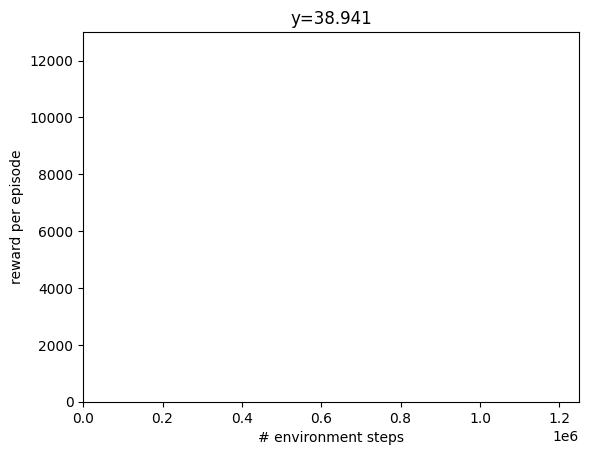

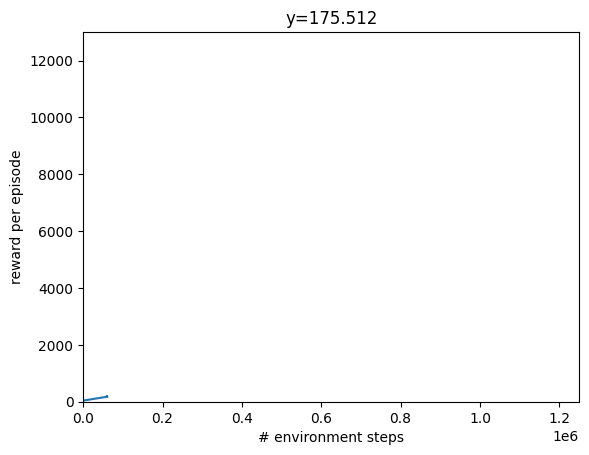

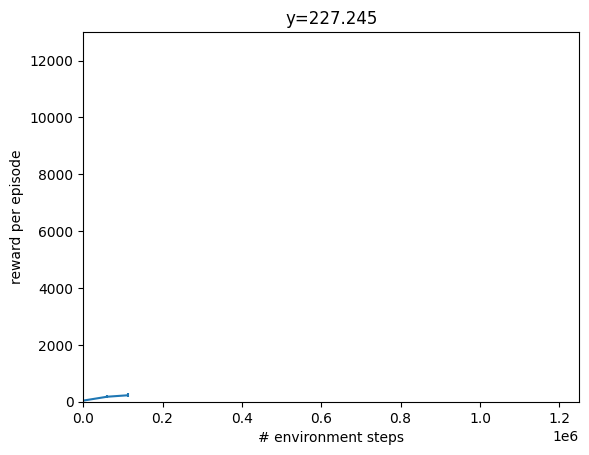

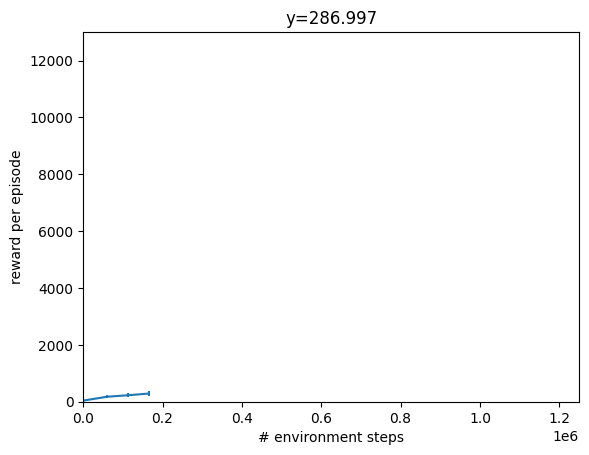

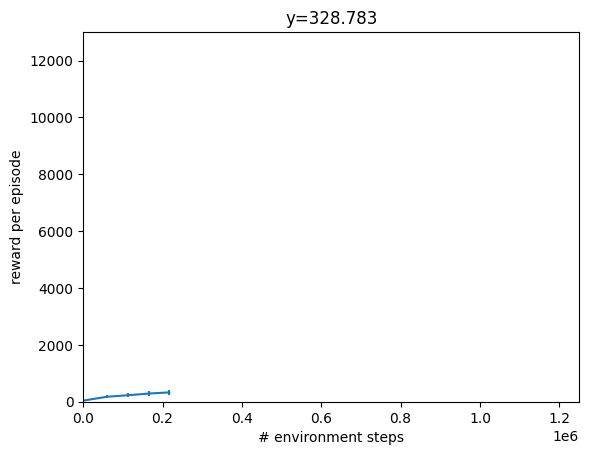

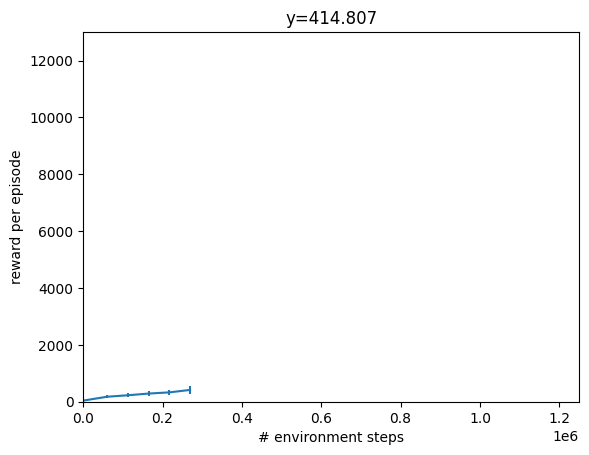

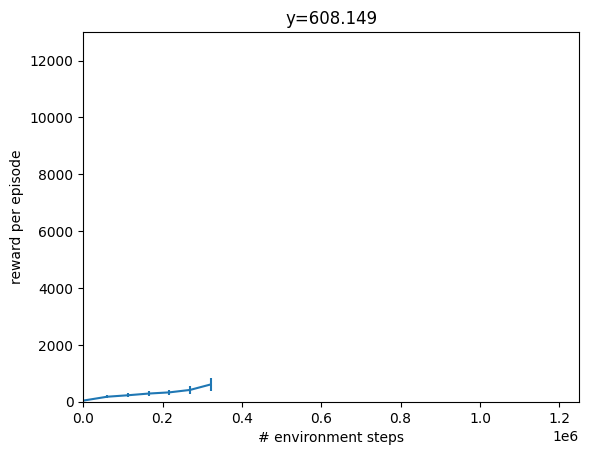

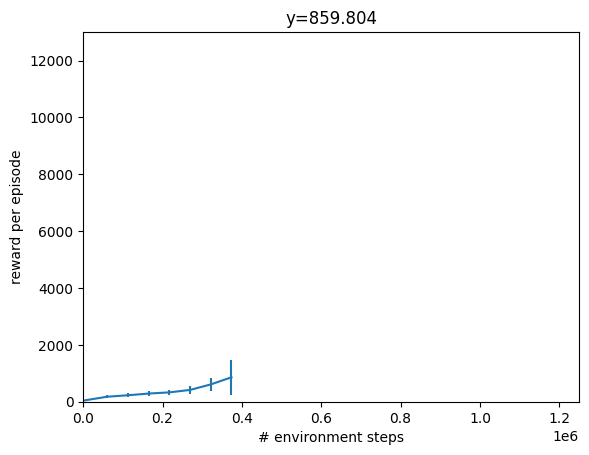

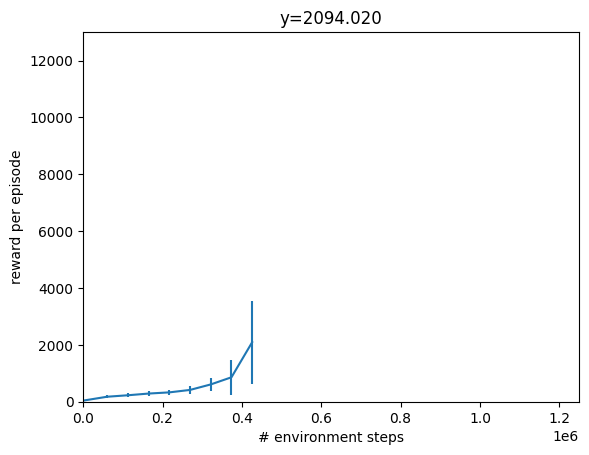

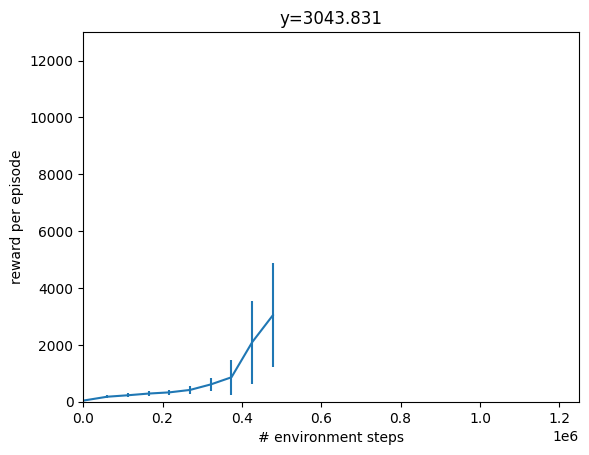

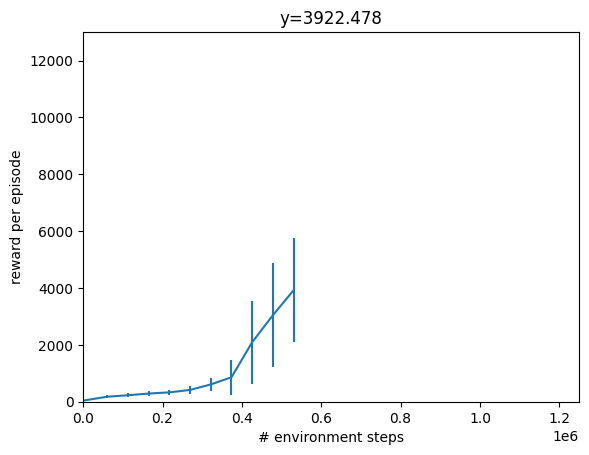

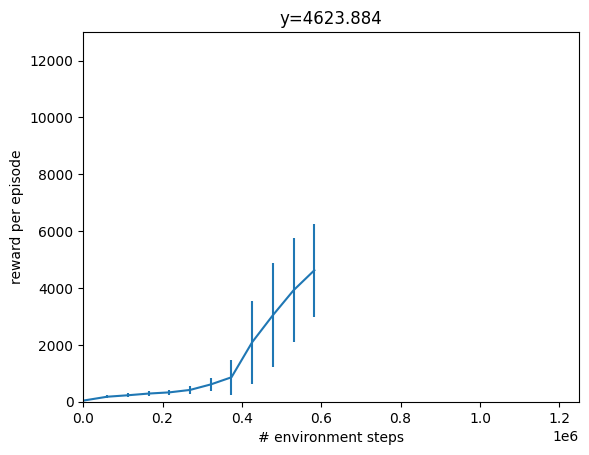

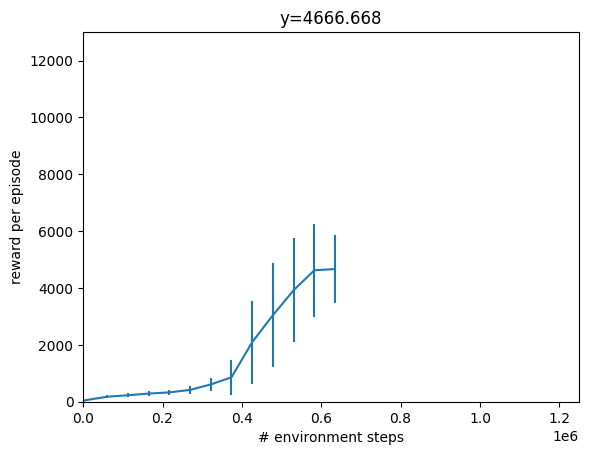

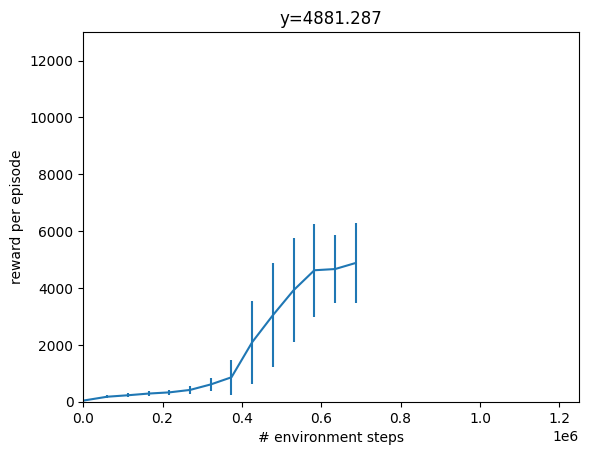

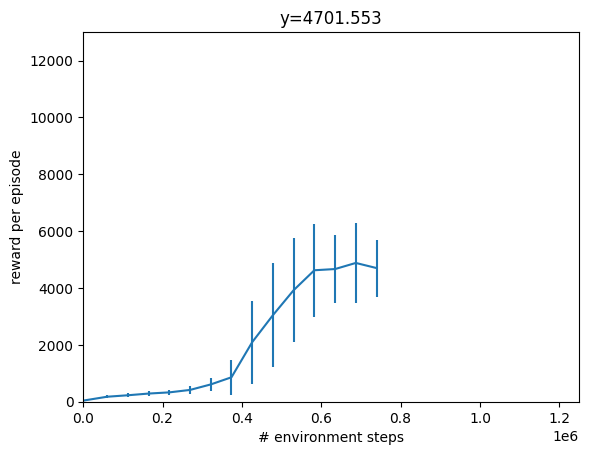

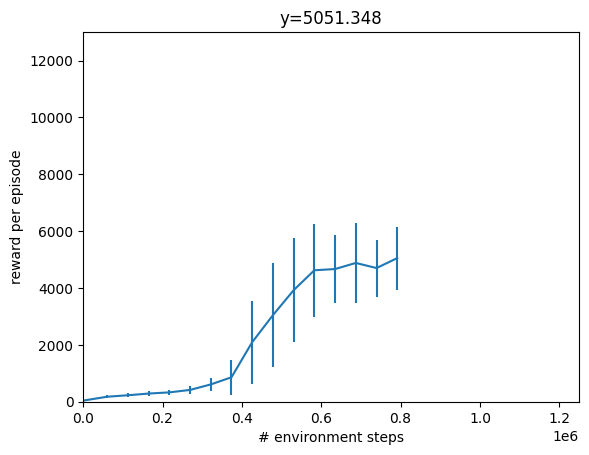

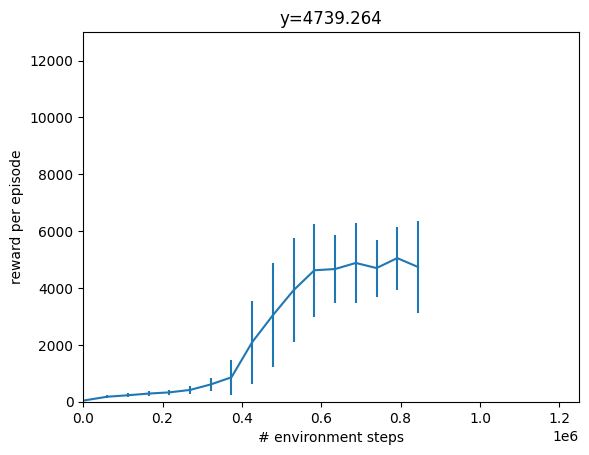

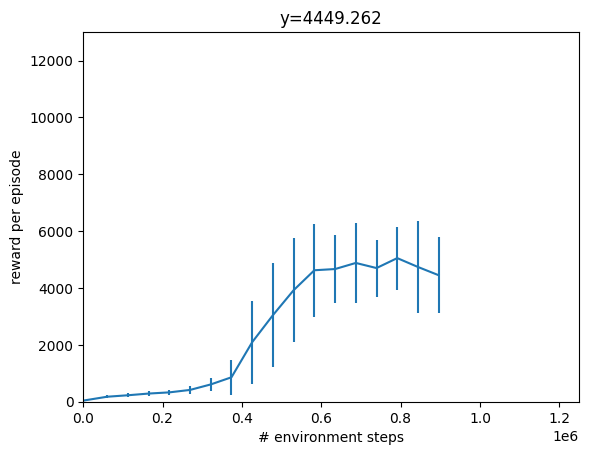

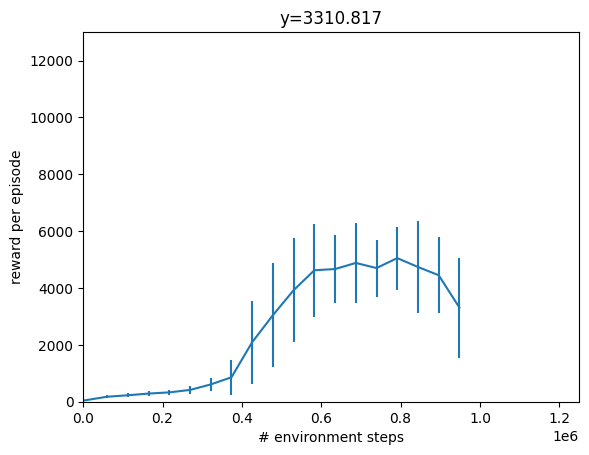

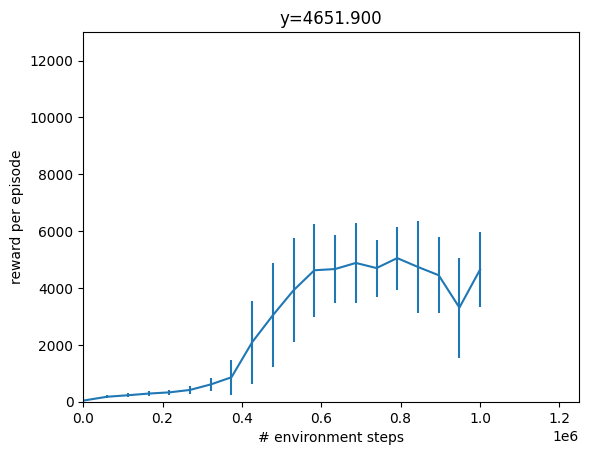

time to jit: 0:03:15.008662
time to train: 0:10:46.643908


In [ ]:
#@title SAC Trening Właściwy
#wywołanie funkcji trenującej ze wskazaniem środowiska i funkcji postępu
# zwraca funkcję predykcji i parametry polityki
make_inference_fn, params, _= train_fn(environment=env, progress_fn=progress)

# time to jit to czas od uruchomienia do bycia skompilowanym i gotowym fo użycia w optymalnej formie
# w skrócie czas od uruchomienia kodu do zaczęcia trenowania
print(f'time to jit: {times[1] - times[0]}')
print(f'time to train: {times[-1] - times[1]}')

In [ ]:
#@title Save Model - SAC

model_path_sac = savepath + 'mjx_brax_SAC_'+timestamp
model.save_params(model_path_sac, params)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#@title Load Model and Define Inference Function
model_name = 'mjx_brax_SAC_'+timestamp
model_path = savepath+model_name
params = model.load_params(model_path)

# z tego co zrozumiałem aktualnie niemożliwe jest w czytanie modelu bez wcześniejszego
# trenowania. Ma to coś wspólnego z tymi funckjami inference
inference_fn = make_inference_fn(params)
jit_inference_fn = jax.jit(inference_fn)

In [ ]:
#@title Wizualizacja Polityki
eval_env = envs.get_environment(env_name)

jit_reset = jax.jit(eval_env.reset)
jit_step = jax.jit(eval_env.step)

In [ ]:
# initialize the state
rng = jax.random.PRNGKey(0)
state = jit_reset(rng)
rollout = [state.pipeline_state]

# grab a trajectory
n_steps = 500
render_every = 2

for i in range(n_steps):
  act_rng, rng = jax.random.split(rng)
  ctrl, _ = jit_inference_fn(state.obs, act_rng)
  state = jit_step(state, ctrl)
  rollout.append(state.pipeline_state)

  if state.done:
    break

#zapisanie do pliku i wyświetlenie
video1 = env.render(rollout[::render_every], camera='side')
media.write_video(savepath + model_name +'.mp4', video1, fps=20)
media.show_video(video1, fps=1.0 / env.dt / render_every)

In [ ]:
#@title Polityka MJX w środowisku MuJoCo
mj_model = eval_env._model
mj_data = mujoco.MjData(mj_model)

renderer = mujoco.Renderer(mj_model)
ctrl = jp.zeros(mj_model.nu)

images = []
for i in range(n_steps):
  act_rng, rng = jax.random.split(rng)

  obs = eval_env._get_obs(mjx.put_data(mj_model, mj_data), ctrl)
  ctrl, _ = jit_inference_fn(obs, act_rng)

  mj_data.ctrl = ctrl
  for _ in range(eval_env._n_frames):
    mujoco.mj_step(mj_model, mj_data)  # Physics step using MuJoCo mj_step.

  if i % render_every == 0:
    renderer.update_scene(mj_data, camera='side')
    images.append(renderer.render())

media.show_video(images, fps=1.0 / eval_env.dt / render_every)

## Notatki
**MuJoCo** - (Multi Joint dynamics with Contact) środowisko symulacyjne wydajne obliczeniowo, umożliwia efektywną symulację wieloczłonowych układów mechanicznych z uwzględnieniem kolizji, dobrze nadaje się do uczenia maszynowego

**MuJoCo XLA** - (Accelerated Linear Algebra), inaczej MJX, jeszcze lepiej wykorzystuje dostępną moc obliczeniową, poprzez hardware accelerartion na GPU TPU przyspiesza trenowanie modeli, też pisany w JAX.
https://mujoco.readthedocs.io/en/latest/mjx.html#tutorial-notebook

**JAX** -
https://jax.readthedocs.io/en/latest/notebooks/quickstart.html
https://github.com/google/jax


**Brax** - physics engine, napisany w JAX służący do symulacji wieloczłonowych układów mechanicznych, zaprojektowany z myślą o accelerated hardware, przystosowany do skalowania ilości symulacji
https://github.com/google/brax

**jit** - (Just In Time, ale nazwa jest myląca) sposób uruchamiania porgramu który polega na uruchomieniu programu, obserwacji w jaki sposób funkcjonuje, i pewnej optymalizacji na podstawie tej obserwacji. W naszym przypadku polecenia jax.jit optymalizują przekazane funkcje by wykonywały się wydajnie dzięki XLA.
https://www.youtube.com/watch?v=d7KHAVaX_Rs
https://jax.readthedocs.io/en/latest/jax-101/02-jitting.html

**Flax** - w naszym przypadku format w którym zapisywane były polityki
https://github.com/google/flax

**SAC** - nasz Soft Actor Critic
https://github.com/google/brax/blob/main/brax/training/agents/sac/train.py
https://arxiv.org/pdf/1812.05905.pdf


**Pozostałe inspiracje:**
https://www.codeproject.com/Articles/5280281/Teaching-a-Robot-to-Walk-with-AI-Introduction-to-C
https://github.com/dongminlee94/deep_rl?tab=readme-ov-file
https://github.com/pranz24/pytorch-soft-actor-critic
https://colab.research.google.com/github/google/brax/blob/main/notebooks/training.ipynb#scrollTo=4YlZvIG320sK
https://colab.research.google.com/github/google-deepmind/mujoco/blob/main/mjx/tutorial.ipynb






## Argumenty funkcji Trenującej
1. **num_timesteps**: Określa łączną liczbę kroków środowiskowych, które będą wykorzystane do treningu. Im większa wartość, tym dłuższy trening.

2. **num_evals**: Liczba ocen wykonywanych podczas treningu. Oceny służą do monitorowania postępu algorytmu na podstawie nagród uzyskanych na różnych trajektoriach.

3. **reward_scaling**: Współczynnik skalowania nagrody. Może być używany do regulacji wpływu nagród na proces treningu.

4. **episode_length**: Określa maksymalną długość pojedynczej trajektorii w krokach środowiskowych.

5. **normalize_observations**: Wskazuje, czy obserwacje mają być normalizowane przed przetwarzaniem.

6. **action_repeat**: Ile razy każda akcja ma być powtórzona, zanim będzie wprowadzona do środowiska.

7. **discounting**: Parametr dyskontowania używany w obliczeniach nagrody z sumy nagród przyszłych.

8. **learning_rate**: Szybkość uczenia algorytmu.

9. **num_envs**: Liczba równoległych środowisk używanych do zbierania trajektorii.

10. **batch_size**: Rozmiar partii danych używanych w jednym kroku optymalizacji.

11. **grad_updates_per_step**: Ile aktualizacji gradientu ma być wykonanych w jednym kroku optymalizacji.

12. **max_devices_per_host**: Maksymalna liczba urządzeń używanych do równoległego przetwarzania na jednym hoście.

13. **max_replay_size**: Maksymalny rozmiar pamięci przejść do przechowywania w algorytmie replay buffer.

14. **min_replay_size**: Minimalny rozmiar pamięci przejść wymagany do rozpoczęcia treningu.

15. **seed**: Ziarno (seed) używane do inicjalizacji generatora liczb losowych, co umożliwia reprodukowalność wyników.
